# Call Libraries

In [1]:
import matlab.engine
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm
from joblib import Parallel, delayed
from mpire import WorkerPool
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

C:\Users\Remote\anaconda3\envs\PyMatlab\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Remote\AppData\Local\Temp\ipykernel_408\3148525863.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/

# Run Matlab In Series For All Locations

In [ ]:
eng=matlab.engine.start_matlab("-desktop") #Start MATLAB and show desktop

In [ ]:
#Set XY location and run on workspace

def RunXYKite(xInd=20, yInd=20,eng=eng):
        
    Location=str('xInd ='+str(xInd)+'; yInd ='+str(yInd)+';')
    eng.eval(Location,nargout=0)
    eng.specXY_plantOptMultiObj_LF_Python(nargout=0)

    #Get variables from workspace
    uopt=eng.workspace['uopt']
    mFuse=eng.workspace['mFuse']
    mWing=eng.workspace['mWing']
    Power=eng.workspace['Power']
    LCOEBest=eng.workspace['LCOEBest']
    CLCD=eng.workspace['CLCD']
        
    XYKite = {
      "X": xInd,
      "Y": yInd,
      "uopt": uopt,
      "mFuse": mFuse,
      "mWing": mWing,
      "Power": Power,
      "LCOEBest": LCOEBest,
      "CLCD": CLCD
    }
    
    return XYKite

In [ ]:
SaveDir=[]
for i in tqdm(range(41,46,1)):
    for j in range(1,51,1):
        XYKite=RunXYKite(xInd=i, yInd=j)
        SaveDir.append(XYKite)
latVec=eng.workspace["DataSet"]["latVec"]
lonVec=eng.workspace["DataSet"]["lonVec"]
eng.quit()
import numpy as np
np.savez("Save_V9.npz",Results=SaveDir,lat=latVec[0],long=lonVec[0])

# Read as a NPZ File

In [ ]:
Save=[]
for i in range(1,11,1):
    Data=np.load("Save_V"+str(i)+".npz",allow_pickle=True)
    Results=Data["Results"]
    lat=Data["lat"]
    long=Data["long"]
    for j in range(len(Results)):
        Save.append(Results[j])

np.savez("Save_Platform.npz",Results=Save,lat=lat,long=long)

In [ ]:
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

In [ ]:
def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
  ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
  ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
  X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
  Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

  min_latitude=np.min(Lat)
  max_latitude=np.max(Lat)

  min_longitude=np.min(Long)
  max_longitude=np.max(Long)

  xlim =[min_longitude,max_longitude]
  ylim=[min_latitude, max_latitude]

  xlim =[-78.6,-74.4]
  ylim=[33.7, 36.7]

  df = gpd.read_file(ShapeFileCoast)
  df1 = gpd.read_file(ShapeFileStates)

  fig, ax = plt.subplots(figsize  = None)
  df.plot(color='black',linewidth=1,ax=ax)
  df1.plot(color='black',linewidth=1,ax=ax)

  count=0
  for I_lat in range(len(Lat)):
    for I_long in range(len(Long)):

      Y_LONG[count]=Lat[I_lat]
      X_LAT[count]=Long[I_long]
      count=count+1

  Variable=np.reshape(Variable,(-1))
#   X_LAT=X_LAT[Variable<9000]
#   Y_LONG=Y_LONG[Variable<9000]
#   Variable=Variable[Variable<9000]

  Variable2=np.reshape(Variable2,(-1))
  X_LAT=X_LAT[Variable2<300]
  Y_LONG=Y_LONG[Variable2<300]
  Variable=Variable[Variable2<300]

  plt.scatter(X_LAT,Y_LONG,c=Variable, s=5, cmap='jet')
  

  ticks = np.linspace(Variable.min(), Variable.max(), 10, endpoint=True)
  #ticks = np.linspace(Variable.min(), 200, 10, endpoint=True)
  clb=plt.colorbar(format='%.1f', ticks=ticks)

  clb.ax.set_title('LCOE [$/MWh]')
  #clb.ax.set_title('mFuse [kg]')
  #clb.ax.set_title('Power [KW]')
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)

  plt.savefig("Power",dpi=1200)
  return plt.show()


In [ ]:
Variable=np.ones((50,50))*-1
Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

In [ ]:
PlotData(Variable, Lat=lat[0], Long=long[0])

In [ ]:
np.sum(Variable<1000)/(50*50)

## Report Q2

In [107]:
#Data=np.load("SaveSeabed.npz",allow_pickle=True)
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

Variable=np.ones((50,50))*-1
#Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    c=Results[i]["Power"]
    #c=Results[i]["mFuse"]
    c=Results[i]["mWing"]
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
    ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
    ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
    X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
    Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

    min_longitude=-78.5
    max_longitude=-74.5+1/50

    min_latitude=33.5 
    max_latitude=37+1/50

    xlim =[min_longitude,max_longitude]
    ylim=[min_latitude, max_latitude]

    
    df = gpd.read_file(ShapeFileCoast)
    df1 = gpd.read_file(ShapeFileStates)

    fig, ax = plt.subplots(figsize  = None)
    df.plot(color='black',linewidth=1,ax=ax)
    df1.plot(color='black',linewidth=1,ax=ax)

    count=0
    for I_lat in range(len(Lat)):
        for I_long in range(len(Long)):

          Y_LONG[count]=Lat[I_lat]
          X_LAT[count]=Long[I_long]
          count=count+1

        
    Variable=np.reshape(Variable,(-1))
#     X_LAT=X_LAT[Variable<9000]
#     Y_LONG=Y_LONG[Variable<9000]
#     Variable=Variable[Variable<9000]

    Variable2=np.reshape(Variable2,(-1))
    X_LAT=X_LAT[Variable2<300]
    Y_LONG=Y_LONG[Variable2<300]
    Variable=Variable[Variable2<300]

    plt.scatter(X_LAT,Y_LONG,c=Variable, s=5, cmap='jet')


    ticks = np.linspace(Variable.min(), Variable.max(), 10, endpoint=True)
    #ticks = np.linspace(Variable.min(), 200, 10, endpoint=True)
    clb=plt.colorbar(format='%.f', ticks=ticks)


    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    #clb.ax.set_title('LCOE $/MWh')
    #clb.ax.set_title('Power [kW]')
    #clb.ax.set_title('mFuse [kg]')
    clb.ax.set_title('mWing [kg]')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    plt.savefig("mWing_KiteSeabed.png",bbox_inches='tight',dpi=700)
    return plt.show()

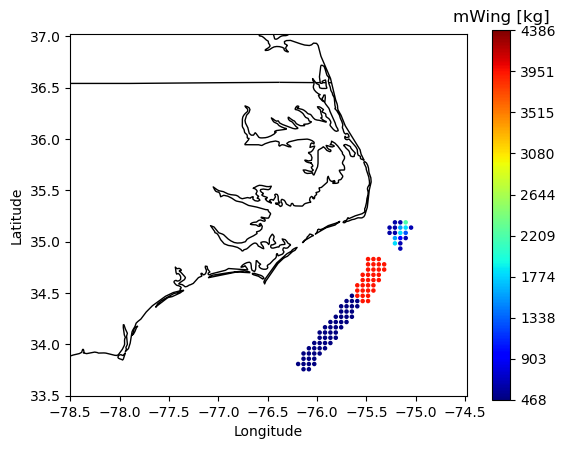

In [108]:
PlotData(Variable, Lat=lat[0], Long=long[0])

## Combine Wind Kite

In [ ]:
#Data=np.load("SaveSeabed.npz",allow_pickle=True)
Data=np.load("Save_Platform.npz",allow_pickle=True)
Results=Data["Results"]
lat=Data["lat"]
long=Data["long"]

Variable=np.ones((50,50))*-1
#Variable2=np.ones((50,50))*-1

for i in range(len(Results)):
    a=Results[i]["X"]-1
    b=Results[i]["Y"]-1
    c=Results[i]["LCOEBest"]*1000
    c=Results[i]["Power"]
    #c=Results[i]["mFuse"]
    c=Results[i]["mWing"]
    Variable[a,b]=c
    Variable2[a,b]=Results[i]["LCOEBest"]*1000

def PlotData(Variable,Lat=lat,Long=long,Variable2=Variable2):
    ShapeFileCoast="./GEO_data/ne_10m_coastline.shp"
    ShapeFileStates="./GEO_data/ne_10m_admin_1_states_provinces_lines.shp"
    X_LAT=np.zeros((int(len(Lat)*len(Long))),dtype=float)
    Y_LONG=np.zeros((int(len(Lat)*len(Long))),dtype=float)

    min_longitude=-78.5
    max_longitude=-74.5+1/50

    min_latitude=33.5 
    max_latitude=37+1/50

    xlim =[min_longitude,max_longitude]
    ylim=[min_latitude, max_latitude]

    
    df = gpd.read_file(ShapeFileCoast)
    df1 = gpd.read_file(ShapeFileStates)

    fig, ax = plt.subplots(figsize  = None)
    df.plot(color='black',linewidth=1,ax=ax)
    df1.plot(color='black',linewidth=1,ax=ax)

    count=0
    for I_lat in range(len(Lat)):
        for I_long in range(len(Long)):

          Y_LONG[count]=Lat[I_lat]
          X_LAT[count]=Long[I_long]
          count=count+1